<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/logo_CV.jpeg" style="width:1500px;heigth:100px">

# Transfer Learning
- *standing on the shoulder of giants*. Chartres
- *If I have seen further it is by standing on the shoulders of Giants*. Newton

## <span style="color:red"> Outline </span> 

1. **Transfer Learning**
2. **Freeze the convolutional base**
3. **Train some layers and freeze other layers**

In [2]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io
import os
import sys

## <span style="color:green"> If you are in colaboratoy </span>: 

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/cv-uis-student/notebooks
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/cv-uis-student/notebooks
/content/drive/My Drive/cv-uis-student/notebooks


## <span style="color:red"> 1. Transfer Learning </span> 

A way to quickly solve a classification problem from a pre-trained image. Transfer learning allows build accurate models without start from scratch. 

- Start from learning patterns of other problems. 

**Advantajes**

- It work into same deep learning scheme. 
- Some SoA are based on transfer learning
 
**Steps**

- Load a pre-trained model: Inception, Mobilenet
- Train some layers and leave the others frozen
    - frozen layer does not change during training

### CNN Models

The CNN achitectures, according to Yosinski et al. (2014), *if first-layer features are general and last-layer features are specific, then there must be a transition from general to specific somewhere in the network*
    - if you’ve a small dataset and a large number of parameters, you’ll leave more layers frozen to avoid overfitting.
    

**Go to the action!**

We should load the local image set

In [6]:
path_classes = '../data/image_set/'
classes_names = os.listdir(path_classes)
print( classes_names[0:5])
classes_names = classes_names[0:5]

list_imgs = []
for i, name_class in enumerate(classes_names):
    list_imgs = list_imgs +[name_class+ "/"+ s for s in (os.listdir(path_classes + classes_names[i]))]
print( len(list_imgs))
array_imgs = np.array(list_imgs)
print( array_imgs[0], array_imgs.shape)

['accordion', 'brain', 'butterfly', 'car_side', 'chair']
429
accordion/image_0012.jpg (429,)


In [7]:
perm = np.random.permutation(len(list_imgs))
perm_arr_images = array_imgs[perm]

val_train = int(perm_arr_images.shape[0]*0.8)
array_imgs_train = perm_arr_images[0:val_train]
array_imgs_test  = perm_arr_images[val_train:]


print( array_imgs_train.shape, array_imgs_test.shape)
print( array_imgs_train.shape[0]+ array_imgs_test.shape[0])
print( array_imgs_test[0])

(343,) (86,)
429
brain/image_0032.jpg


In [9]:
print( classes_names)
dic_classes = {}
for index, name in enumerate(classes_names):
    dic_classes[name] = index
    print( index)

['accordion', 'brain', 'butterfly', 'car_side', 'chair']
0
1
2
3
4


In [10]:
import gc

arr_h_train = []
arr_h_test = []
y_train = []
y_test =[]




for i in array_imgs_train: 
    im_ = tf.contrib.keras.preprocessing.image.load_img((path_classes+i), target_size=(224, 224))
    ima_ = tf.contrib.keras.preprocessing.image.img_to_array(im_)
    arr_h_train.append(ima_)
    y_train.append(dic_classes[i.split('/')[0]])


for i in array_imgs_test: 
    im_ = tf.contrib.keras.preprocessing.image.load_img((path_classes+i), target_size=(224, 224))
    ima_ = tf.contrib.keras.preprocessing.image.img_to_array(im_)
    arr_h_test.append(ima_)
    y_test.append(dic_classes[i.split('/')[0]])
   
    
gc.collect() # explicitelly clean memory
arr_h_train = np.array(arr_h_train)
arr_h_test = np.array(arr_h_test)
ya_train = np.array(y_train)
ya_test = np.array(y_test)
print (arr_h_test.shape, arr_h_train.shape, ya_train.shape, ya_test.shape)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(86, 224, 224, 3) (343, 224, 224, 3) (343,) (86,)


In [11]:
np.max(ya_train)

4

## <span style="color:red"> 2. Freeze the convolutional base </span>    

A basic transfer learning approach is implemented when *new dataset* is **small and similar** to *original dataset*

- we will be training only the classifiers (FC layers). To train the entire entire network can lead to **overfitting**
- The first step is to select a pre-trained model: Inception, VGG, Resnet, among others.
- Then freeze all layers except FC layers and re-train.


Now, we load a pre-trained model: the  `VGG 16`

In [12]:
model_A = tf.keras.applications.MobileNet(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 1s 0us/step


In [13]:
model_A.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

When you train model_B_on_A , it will also affect model_A .

In [0]:
model_B_on_A = tf.keras.models.Sequential(model_A.layers[:-1])
#model_B_on_A.add(tf.keras.layers.GlobalAvgPool2D(input_shape=(1,1,1000)))
model_B_on_A.add(tf.keras.layers.Dense(100, activation='relu'))
model_B_on_A.add(tf.keras.layers.Dense(5, activation='sigmoid'))

In [0]:
model_B_on_A.summary()

Now we train `model_B_on_A` for `task B`: **image-set**.  
- Since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs. We need sufficient epochs.
- Freeze the reused layers during the first few epochs, train able attribute to False and compile the mode

In [0]:
for layer in model_B_on_A.layers[:-2]:
    layer.trainable = False

and train

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model_B_on_A.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [82]:
history = model_B_on_A.fit(arr_h_train, ya_train, epochs=20, batch_size=10,validation_data=(arr_h_test, ya_test))

Train on 343 samples, validate on 86 samples
Epoch 1/20
343/343 [==============================] - 3s 9ms/sample - loss: 1.3317 - acc: 0.5364 - val_loss: 1.5400 - val_acc: 0.2791
Epoch 2/20
343/343 [==============================] - 1s 2ms/sample - loss: 0.6535 - acc: 0.7755 - val_loss: 2.0134 - val_acc: 0.3256
Epoch 3/20
343/343 [==============================] - 1s 2ms/sample - loss: 0.4208 - acc: 0.8484 - val_loss: 2.5786 - val_acc: 0.3721
Epoch 4/20
343/343 [==============================] - 1s 2ms/sample - loss: 0.3641 - acc: 0.8542 - val_loss: 3.0745 - val_acc: 0.3721
Epoch 5/20
343/343 [==============================] - 1s 2ms/sample - loss: 0.2293 - acc: 0.9155 - val_loss: 3.1555 - val_acc: 0.3140
Epoch 6/20
343/343 [==============================] - 1s 2ms/sample - loss: 0.2023 - acc: 0.9329 - val_loss: 3.6505 - val_acc: 0.4070
Epoch 7/20
343/343 [==============================] - 1s 2ms/sample - loss: 0.0619 - acc: 0.9854 - val_loss: 3.7962 - val_acc: 0.3721
Epoch 8/20
343/34

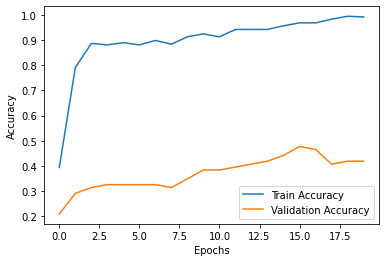

In [56]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


## <span style="color:orange">Student Challenge</span>:

- Now, unfreeze the reused layers (first layers) and training from *fine-tunning* using  few epochs. 
- Remove the full-connected layer and take the GlobalAvgPool2D with sigmoid activations

In [0]:
#unfrezee




In [0]:
# compile model



In [0]:
# fit and test model




Train on 280 samples, validate on 71 samples
Epoch 1/7
280/280 [==============================] - 124s - loss: 1.5944 - acc: 0.3571 - val_loss: 1.5973 - val_acc: 0.3239
Epoch 2/7
280/280 [==============================] - 102s - loss: 1.5946 - acc: 0.3571 - val_loss: 1.5973 - val_acc: 0.3239
Epoch 3/7
280/280 [==============================] - 102s - loss: 1.5941 - acc: 0.3571 - val_loss: 1.5974 - val_acc: 0.3239
Epoch 4/7
280/280 [==============================] - 106s - loss: 1.5942 - acc: 0.3571 - val_loss: 1.5974 - val_acc: 0.3239
Epoch 5/7
280/280 [==============================] - 106s - loss: 1.5943 - acc: 0.3571 - val_loss: 1.5974 - val_acc: 0.3239
Epoch 6/7
280/280 [==============================] - 102s - loss: 1.5945 - acc: 0.3571 - val_loss: 1.5975 - val_acc: 0.3239
Epoch 7/7
280/280 [==============================] - 103s - loss: 1.5941 - acc: 0.3571 - val_loss: 1.5975 - val_acc: 0.3239


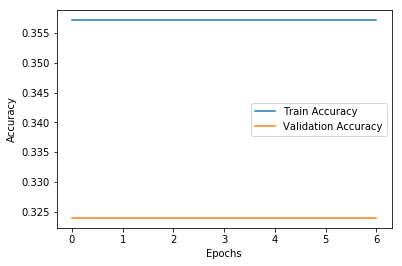

In [0]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## <span style="color:red"> 3. Train some layers and freeze other layers </span>    

In some cases, we need to re-train more layers and *personalize* deeply the network. So, we can doing same procedure but only freezing first base layers

In [0]:
gc.collect() #

893

In [0]:
based_model=tf.keras.applications.MobileNet(weights='imagenet')
trans_model = tf.keras.models.Sequential(based_model.layers[:-2])

for layer in trans_model.layers[:5]:
    layer.trainable = False

#personalizando layers

trans_model.add(tf.keras.layers.GlobalAvgPool2D(input_shape=(1,1,1000)))
trans_model.add(tf.keras.layers.Dense(1024, activation='relu'))
trans_model.add(tf.keras.layers.Dense(1024, activation='relu'))
trans_model.add(tf.keras.layers.Dense(512, activation='relu'))
trans_model.add(tf.keras.layers.Dense(5, activation='sigmoid'))

In [46]:
trans_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)     

We can then fix the block of layers that will be trained 

and run it!

In [0]:
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
trans_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [48]:
history = trans_model.fit(arr_h_train, ya_train, epochs=10, batch_size=32,validation_data=(arr_h_test, ya_test))

Train on 343 samples, validate on 86 samples
Epoch 1/10
343/343 [==============================] - 5s 14ms/sample - loss: 1.4352 - acc: 0.4227 - val_loss: 1.4563 - val_acc: 0.3372
Epoch 2/10
343/343 [==============================] - 1s 4ms/sample - loss: 0.5207 - acc: 0.8834 - val_loss: 1.5664 - val_acc: 0.2907
Epoch 3/10
343/343 [==============================] - 1s 4ms/sample - loss: 0.0794 - acc: 0.9854 - val_loss: 1.6878 - val_acc: 0.3605
Epoch 4/10
343/343 [==============================] - 1s 4ms/sample - loss: 0.0329 - acc: 0.9913 - val_loss: 1.9982 - val_acc: 0.3721
Epoch 5/10
343/343 [==============================] - 1s 4ms/sample - loss: 0.0071 - acc: 1.0000 - val_loss: 1.9996 - val_acc: 0.3837
Epoch 6/10
343/343 [==============================] - 1s 4ms/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.9991 - val_acc: 0.3605
Epoch 7/10
343/343 [==============================] - 1s 4ms/sample - loss: 0.0078 - acc: 1.0000 - val_loss: 2.0626 - val_acc: 0.3837
Epoch 8/10
343/3

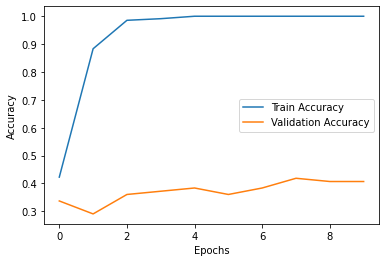

In [49]:
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Concluding remarks 

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/TL_1.png" style="width:500px">

- Very Deep Networks are expensive to train and their could take weeks to train.
- If new dataset is small and similar to original dataset then train the FC layers
- If new dataset is larger and similar to original dataset then we fine-tune through the full net
    - You can freeze the first layers, they are common edges
- Train the entire model but you can summarize the model
    - add FC layers
    - set the weights for first layers. 

## <span style="color:orange">Student Challenge</span>: 


- Design different experiments according to figure. Justify the selection of use different classes and levels of transfer learning. 
    - Try with  Inception
- Use a transfer learning strategy to train only middle layers.     
- How work this kind of methodology in you final project?  






## References

[1] Krizhevsky, A., Sutskever, I. and Hinton, G.E., 2012. Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097–1105)

[2] Pan, S.J. and Yang, Q., 2010. A survey on transfer learning. IEEE Transactions on knowledge and data engineering, 22(10), pp.1345–1359

[3]  Simonyan, K. and Zisserman, A., 2014. Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">